<h1 align="center"> Auto insurance - Predicting the total cost & the insurance premium of bodily injury claims - Modelling </h1>

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, r2_score, mean_squared_error, mean_absolute_error
import scipy.stats
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from category_encoders import CountEncoder, TargetEncoder
import shap
from sklearn.neural_network import MLPRegressor

## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Opening Dataset

In [39]:
# Load the training dataset
training_data = pd.read_csv('training_clean.csv')

In [40]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,85,3,15080.0,0,L46,L,72.012883,365.0,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370.0,1,O38,O,39.550411,365.0,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,85,0,39650.0,0,Q28,Q,169.529148,365.0,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600.0,1,L6,L,58.894688,365.0,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065.0,0,N4,N,109.631885,365.0,2,0,0.0,0.0


The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [41]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99979 entries, 0 to 99978
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PolNum      99979 non-null  int64  
 1   CalYear     99979 non-null  int64  
 2   Gender      99979 non-null  object 
 3   Type        99979 non-null  object 
 4   Category    99979 non-null  object 
 5   Occupation  99979 non-null  object 
 6   Age         99979 non-null  int64  
 7   Group1      99979 non-null  int64  
 8   Bonus       99979 non-null  int64  
 9   Poldur      99979 non-null  int64  
 10  Value       99979 non-null  float64
 11  Adind       99979 non-null  int64  
 12  SubGroup2   99979 non-null  object 
 13  Group2      99979 non-null  object 
 14  Density     99979 non-null  float64
 15  Exppdays    99979 non-null  float64
 16  Numtppd     99979 non-null  int64  
 17  Numtpbi     99979 non-null  int64  
 18  Indtppd     99979 non-null  float64
 19  Indtpbi     99979 non-nul

In [42]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [43]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
count,9.997900e+04,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000
mean,2.002003e+08,2009.499935,41.124126,10.691725,-9.374319,5.470579,16358.767416,0.512178,117.142810,349.821137,0.147391,0.046780,106.110750,222.793486
std,6.217119e+04,0.500002,14.301168,4.687371,42.481030,4.591067,10253.792535,0.499854,79.493407,26.019809,0.436855,0.219528,444.979787,1859.763345
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,302.500000,0.000000,0.000000,0.000000,0.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.566406,340.000000,0.000000,0.000000,0.000000,0.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14605.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22565.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,85.000000,15.000000,43842.500000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292


In [44]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
PolNum,1.000000,0.972664,0.002436,0.004251,-0.005043,-0.003839,-0.003455,0.001786,0.008234,-0.000613,0.016105,0.001248,0.016661,0.007752
CalYear,0.972664,1.000000,0.001772,0.003736,-0.004583,-0.002483,-0.003646,0.001794,0.008792,-0.001321,0.016163,-0.000018,0.017005,0.007686
Age,0.002436,0.001772,1.000000,0.090984,-0.240476,0.050505,0.018009,0.203077,0.003178,0.000702,-0.162977,-0.097232,-0.137944,-0.054483
Group1,0.004251,0.003736,0.090984,1.000000,-0.025149,0.004468,0.233053,0.020499,0.004397,0.003376,0.091433,0.026593,0.059905,0.002923
Bonus,-0.005043,-0.004583,-0.240476,-0.025149,1.000000,-0.009795,-0.004522,-0.048566,-0.004451,-0.000966,0.232109,0.072716,0.140836,0.038668
Poldur,-0.003839,-0.002483,0.050505,0.004468,-0.009795,1.000000,0.002160,0.012514,-0.001126,0.000556,-0.043410,-0.007581,-0.031188,-0.004157
Value,-0.003455,-0.003646,0.018009,0.233053,-0.004522,0.002160,1.000000,0.008062,0.001496,-0.000369,0.023835,0.007678,0.015609,0.001757
Adind,0.001786,0.001794,0.203077,0.020499,-0.048566,0.012514,0.008062,1.000000,0.003238,0.001833,-0.052193,-0.039510,-0.059232,-0.020369
Density,0.008234,0.008792,0.003178,0.004397,-0.004451,-0.001126,0.001496,0.003238,1.000000,-0.002740,0.120872,0.026306,0.105411,0.021309
Exppdays,-0.000613,-0.001321,0.000702,0.003376,-0.000966,0.000556,-0.000369,0.001833,-0.002740,1.000000,0.066077,0.043648,0.047665,0.024760


In [45]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 85  30   0  40  80 -20 -40 -30  20  50 -50 -10  10  70  60]


In [46]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])

# Calculate the 90th percentile for each numeric column
percentile_90 = numeric_cols.quantile(0.9)

# Count the number of values above the 90th percentile in each column
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculate the percentage of values above the 90th percentile in each column
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Display the percentages
print("Percentage of values above the 90th percentile in each column:")
print(percentage_above_90)

Percentage of values above the 90th percentile in each column:
PolNum      10.000100
CalYear      0.000000
Age          9.535002
Group1       7.822643
Bonus        8.957881
Poldur       7.146501
Value        9.993099
Adind        0.000000
Density      9.696036
Exppdays     0.000000
Numtppd      1.917403
Numtpbi      4.503946
Indtppd     10.000100
Indtpbi      4.503946
dtype: float64


In [47]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtpbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtpbi: p-value = 0.8909201237698269
Cramer's V for Gender and Indtpbi: 0.2094143228030988
Chi-squared test result for Type and Indtpbi: p-value = 0.4342454166427132
Cramer's V for Type and Indtpbi: 0.474807467472142
Chi-squared test result for Category and Indtpbi: p-value = 0.04076705195160662
Cramer's V for Category and Indtpbi: 0.30395740832155865
Chi-squared test result for Occupation and Indtpbi: p-value = 0.9999998862782573
Cramer's V for Occupation and Indtpbi: 0.41282731298393016
Chi-squared test result for Group2 and Indtpbi: p-value = 0.9955568839899501
Cramer's V for Group2 and Indtpbi: 0.630686347859859


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

In [48]:
#  Creating new target variable
training_data['Prime_pbi'] = training_data['Numtpbi'] * training_data['Indtpbi']

In [49]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Prime_pbi
PolNum,1.000000,0.972664,0.002436,0.004251,-0.005043,-0.003839,-0.003455,0.001786,0.008234,-0.000613,0.016105,0.001248,0.016661,0.007752,0.006929
CalYear,0.972664,1.000000,0.001772,0.003736,-0.004583,-0.002483,-0.003646,0.001794,0.008792,-0.001321,0.016163,-0.000018,0.017005,0.007686,0.006803
Age,0.002436,0.001772,1.000000,0.090984,-0.240476,0.050505,0.018009,0.203077,0.003178,0.000702,-0.162977,-0.097232,-0.137944,-0.054483,-0.054624
Group1,0.004251,0.003736,0.090984,1.000000,-0.025149,0.004468,0.233053,0.020499,0.004397,0.003376,0.091433,0.026593,0.059905,0.002923,0.005658
Bonus,-0.005043,-0.004583,-0.240476,-0.025149,1.000000,-0.009795,-0.004522,-0.048566,-0.004451,-0.000966,0.232109,0.072716,0.140836,0.038668,0.040195
Poldur,-0.003839,-0.002483,0.050505,0.004468,-0.009795,1.000000,0.002160,0.012514,-0.001126,0.000556,-0.043410,-0.007581,-0.031188,-0.004157,-0.003916
Value,-0.003455,-0.003646,0.018009,0.233053,-0.004522,0.002160,1.000000,0.008062,0.001496,-0.000369,0.023835,0.007678,0.015609,0.001757,0.002967
Adind,0.001786,0.001794,0.203077,0.020499,-0.048566,0.012514,0.008062,1.000000,0.003238,0.001833,-0.052193,-0.039510,-0.059232,-0.020369,-0.020662
Density,0.008234,0.008792,0.003178,0.004397,-0.004451,-0.001126,0.001496,0.003238,1.000000,-0.002740,0.120872,0.026306,0.105411,0.021309,0.020100
Exppdays,-0.000613,-0.001321,0.000702,0.003376,-0.000966,0.000556,-0.000369,0.001833,-0.002740,1.000000,0.066077,0.043648,0.047665,0.024760,0.024565


In [50]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Prime_pbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Prime_pbi: p-value = 0.8909201237698269
Cramer's V for Gender and Prime_pbi: 0.2094143228030988
Chi-squared test result for Type and Prime_pbi: p-value = 0.4342454166427132
Cramer's V for Type and Prime_pbi: 0.474807467472142
Chi-squared test result for Category and Prime_pbi: p-value = 0.04076705195160662
Cramer's V for Category and Prime_pbi: 0.30395740832155865
Chi-squared test result for Occupation and Prime_pbi: p-value = 0.9999998862782573
Cramer's V for Occupation and Prime_pbi: 0.41282731298393016
Chi-squared test result for Group2 and Prime_pbi: p-value = 0.9955568839899498
Cramer's V for Group2 and Prime_pbi: 0.6306863478598591


#### Step 2. Feature engineering (Data pre-processing)

#### Step A. Predicting the Indtpbi : 

In [94]:
# List of column names to select
columns_to_select_Ind = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays', 
                         'Numtpbi','Indtppd', 'Numtppd']

# Select the columns and assign them to X
X_Ind = training_data[columns_to_select_Ind] # features
y_Ind = training_data["Indtpbi"] # target variable

In [95]:
# Identification of missing values
X_Ind.isnull().sum()

Gender        0
Type          0
Category      0
Occupation    0
PolNum        0
CalYear       0
Age           0
Adind         0
Density       0
Bonus         0
Exppdays      0
Numtpbi       0
Indtppd       0
Numtppd       0
dtype: int64

In [96]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X_Ind.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_Ind.select_dtypes(exclude=['object', 'bool']).columns

In [97]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data


In [98]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [99]:
# As our target variable can be imbalanced
X_train_Ind, X_test_Ind, y_train_Ind, y_test_Ind = train_test_split(X_Ind, y_Ind, test_size=0.1, random_state=42)

In [100]:
preprocessor.fit(X_train_Ind, y_train_Ind)
X_train_Ind = preprocessor.transform(X_train_Ind)
X_test_Ind = preprocessor.transform(X_test_Ind)

#### Step B. Predicting the Primepbi : 

In [72]:
# List of column names to select
columns_to_select = ['Type', 'Occupation', 'Category', 'Gender', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays',
                     'Numtpbi', 'Indtppd', 'Numtppd', 'Indtpbi']

# Select the columns and assign them to X
X = training_data[columns_to_select] # features
y = training_data["Prime_pbi"] # target variable

In [73]:
# Identification of missing values
X.isnull().sum()

Type          0
Occupation    0
Category      0
Gender        0
Age           0
Adind         0
Density       0
Bonus         0
Exppdays      0
Numtpbi       0
Indtppd       0
Numtppd       0
Indtpbi       0
dtype: int64

In [74]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns

In [75]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data

In [76]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [77]:
# As our target variable can be imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [78]:
preprocessor.fit(X_train, y_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#### Step 3. Modelling

#### Step A. Predicting the Indtpbi : 

#### 1. SVR

SVR Regression Metrics (svr_Ind):
Mean Squared Error (svr_Ind): 2832193.190754861
R-squared Score (svr_Ind): 0.21412682635577784
MAE (svr_Ind):
Train_svr_Ind: 189.2106746361376
Test_svr_Ind: 198.01915673037257
MSE (svr_Ind):
Train_svr_Ind: 2719512.715198579
Test_svr_Ind: 2832193.190754861
RMSE (svr_Ind):
Train_svr_Ind: 1649.0945137252077
Test_svr_Ind: 1682.9121161709131
R2 SCORE (svr_Ind):
Train_svr_Ind: 0.2100263729931855
Test_svr_Ind: 0.21412682635577784
MAPE - Mean Absolute Percentage Error (svr_Ind):
Train_svr_Ind: inf
Test_svr_Ind: inf


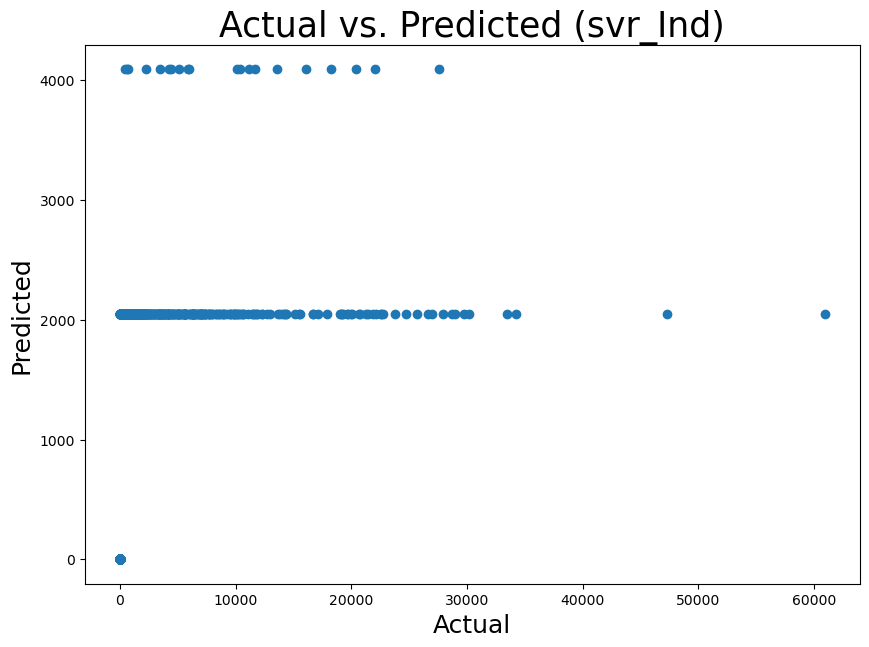

In [79]:
# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_svr_Ind = svr_model.predict(X_test_Ind)

# Evaluate the model
mse_svr_Ind = mean_squared_error(y_test_Ind, y_pred_svr_Ind)
print("SVR Regression Metrics (svr_Ind):")
print(f"Mean Squared Error (svr_Ind): {mse_svr_Ind}")

r2_svr_Ind = r2_score(y_test_Ind, y_pred_svr_Ind)
print(f"R-squared Score (svr_Ind): {r2_svr_Ind}")

# Predicting on TRAIN & TEST DATA
train_predict_svr_Ind = svr_model.predict(X_train_Ind)
test_predict_svr_Ind = svr_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (svr_Ind):")
print("Train_svr_Ind:", mean_absolute_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_absolute_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (svr_Ind):")
print("Train_svr_Ind:", mean_squared_error(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", mean_squared_error(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (svr_Ind):")
print("Train_svr_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_svr_Ind)))
print("Test_svr_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_svr_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (svr_Ind):")
print("Train_svr_Ind:", r2_score(y_train_Ind, train_predict_svr_Ind))
print("Test_svr_Ind:", r2_score(y_test_Ind, test_predict_svr_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_svr_Ind = np.mean(np.abs((y_train_Ind - train_predict_svr_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (svr_Ind):")
print("Train_svr_Ind:", mape_train_svr_Ind)
print("Test_svr_Ind:", np.mean(np.abs((y_test_Ind - test_predict_svr_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_svr_Ind)
plt.show()

#### 2. Linear Regression

Intercept (reg_lin): 235.2365360899066
Coefficients (reg_lin): [-2.90694733e+01  4.51482147e+01 -7.11965608e+00  2.68833326e+00
  1.01728518e+01 -4.19384286e+00 -7.77543821e-01  1.04673996e+03
  1.74181787e+01 -1.22755986e+01 -6.70363009e-01  6.70363009e-01
 -4.98294734e+01 -1.48695986e+01  1.59217779e-01  1.57425243e+01
  3.61459574e+01  1.26513725e+01  6.53225685e+00 -9.99448771e+00
  3.46223086e+00 -3.74412641e+01  3.62895295e+01 -2.58516450e+00
 -1.18485142e+00  4.92175055e+00]
MAE_reg_lin_Ind:
Train_reg_lin_Ind: 250.85961729069757
Test_reg_lin_Ind: 253.21448461600912
MSE_reg_lin_Ind:
Train_reg_lin_Ind: 2344225.5178375454
Test_reg_lin_Ind: 2387127.4617247386
RMSE_reg_lin_Ind:
Train_reg_lin_Ind: 1531.0863848384079
Test_reg_lin_Ind: 1545.0331587783928
R2_SCORE_reg_lin_Ind:
Train_reg_lin_Ind: 0.3190411192054936
Test_reg_lin_Ind: 0.3376230688066537
MAPE_reg_lin_Ind - Mean Absolute Percentage Error:
Train_reg_lin_Ind: inf
Test_reg_lin_Ind: inf


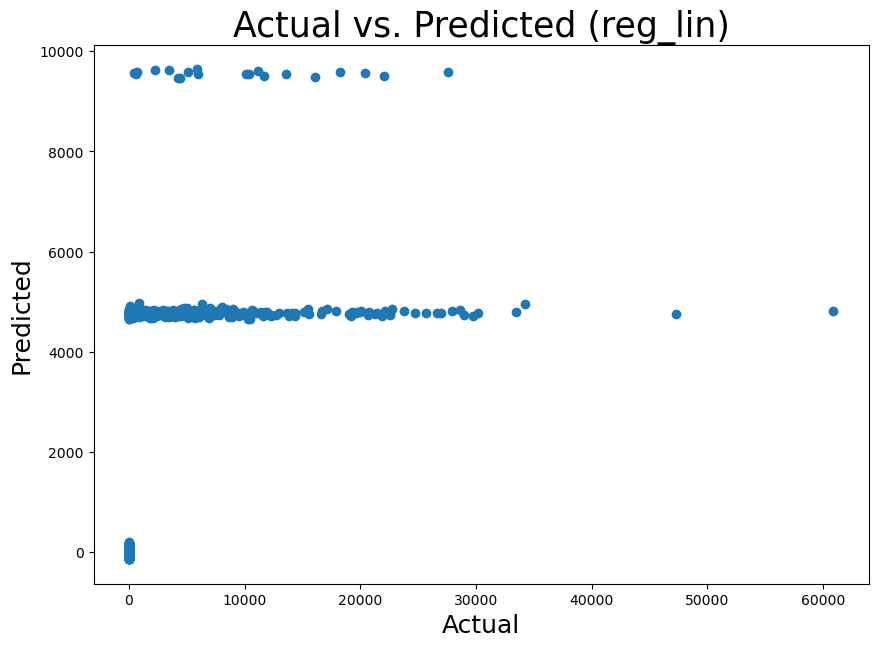

In [80]:
# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_Ind, y_train_Ind)

# Print intercept and coefficients
print("Intercept (reg_lin):", model.intercept_)
print("Coefficients (reg_lin):", model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin_Ind = model.predict(X_train_Ind)
test_predict_reg_lin_Ind = model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_absolute_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_absolute_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_reg_lin_Ind)))
print("Test_reg_lin_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_reg_lin_Ind)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_Ind:")
print("Train_reg_lin_Ind:", r2_score(y_train_Ind, train_predict_reg_lin_Ind))
print("Test_reg_lin_Ind:", r2_score(y_test_Ind, test_predict_reg_lin_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin_Ind, train_predict_reg_lin_Ind = np.array(y_train_Ind), np.array(train_predict_reg_lin_Ind)
mape_train_reg_lin_Ind = np.mean(np.abs((train_y_reg_lin_Ind - train_predict_reg_lin_Ind) / train_y_reg_lin_Ind)) * 100
print("MAPE_reg_lin_Ind - Mean Absolute Percentage Error:")
print("Train_reg_lin_Ind:", mape_train_reg_lin_Ind)
print("Test_reg_lin_Ind:", np.mean(np.abs((np.array(y_test_Ind) - np.array(test_predict_reg_lin_Ind)) / np.array(y_test_Ind))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_reg_lin_Ind)
plt.show()

#### 3. Polynomial Features

Polynomial Regression Metrics (poly_Ind):
Mean Squared Error (poly_Ind): 2595124.2881590896
R-squared Score (poly_Ind): 0.27990838796091544
Intercept (poly_Ind): -855096037438.3392
Coefficients (poly_Ind): [-4.06747946e+08  2.22451913e+11 -2.19680061e+12 ...  0.00000000e+00
  0.00000000e+00 -4.37477461e+09]
MAE (poly_Ind):
Train_poly_Ind: 323.6044414672461
Test_poly_Ind: 349.71832390149746
MSE (poly_Ind):
Train_poly_Ind: 2107958.3652852033
Test_poly_Ind: 2595124.2881590896
RMSE (poly_Ind):
Train_poly_Ind: 1451.8809749029717
Test_poly_Ind: 1610.9389461302032
R2 SCORE (poly_Ind):
Train_poly_Ind: 0.38767283340974845
Test_poly_Ind: 0.27990838796091544
MAPE - Mean Absolute Percentage Error (poly_Ind):
Train_poly_Ind: inf
Test_poly_Ind: inf


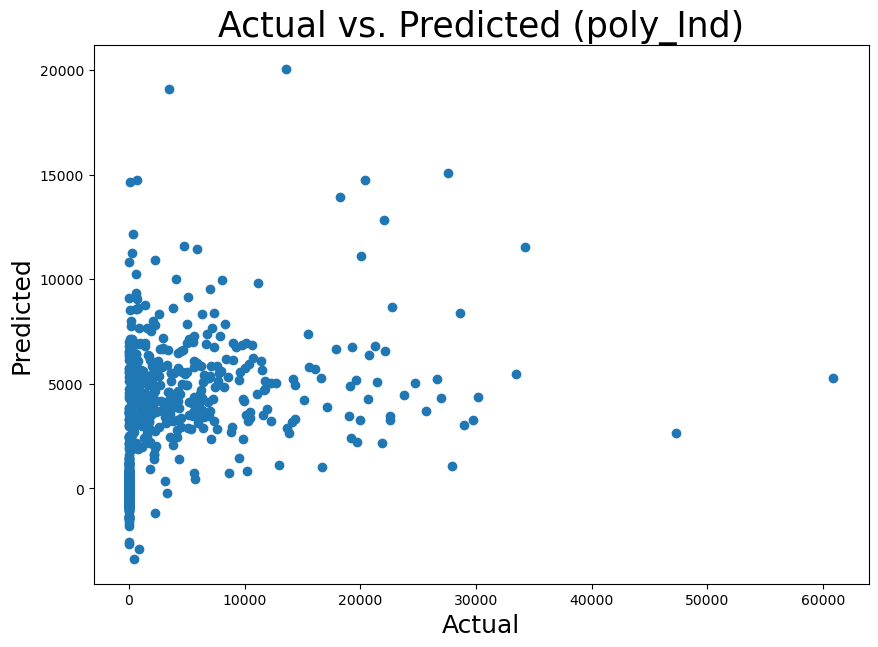

In [81]:
# Define the polynomial regression model
degree = 3  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train_Ind, y_train_Ind)

# Make predictions
y_pred_poly_Ind = poly_model.predict(X_test_Ind)

# Evaluate the model
mse_poly_Ind = mean_squared_error(y_test_Ind, y_pred_poly_Ind)
print("Polynomial Regression Metrics (poly_Ind):")
print(f"Mean Squared Error (poly_Ind): {mse_poly_Ind}")

r2_poly_Ind = r2_score(y_test_Ind, y_pred_poly_Ind)
print(f"R-squared Score (poly_Ind): {r2_poly_Ind}")

# Calculate other metrics
print("Intercept (poly_Ind):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_Ind):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly_Ind = poly_model.predict(X_train_Ind)
test_predict_poly_Ind = poly_model.predict(X_test_Ind)

# Print MAE (Mean Absolute Error)
print("MAE (poly_Ind):")
print("Train_poly_Ind:", mean_absolute_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_absolute_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (poly_Ind):")
print("Train_poly_Ind:", mean_squared_error(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", mean_squared_error(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (poly_Ind):")
print("Train_poly_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_poly_Ind)))
print("Test_poly_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_poly_Ind)))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (poly_Ind):")
print("Train_poly_Ind:", r2_score(y_train_Ind, train_predict_poly_Ind))
print("Test_poly_Ind:", r2_score(y_test_Ind, test_predict_poly_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_poly_Ind = np.mean(np.abs((y_train_Ind - train_predict_poly_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (poly_Ind):")
print("Train_poly_Ind:", mape_train_poly_Ind)
print("Test_poly_Ind:", np.mean(np.abs((y_test_Ind - test_predict_poly_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_poly_Ind)
plt.show()

#### 4. RandomForest with Grid search

Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):
Mean Squared Error (RF_GSCV_Ind): 2356938.18215332
R-squared Score (RF_GSCV_Ind): 0.3459999496720795
Best parameters found by GridSearchCV (RF_GSCV_Ind):
{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 3000}
MAE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 209.34636502666345
Test_RF_GSCV_Ind: 214.71402618173832
MSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 2224119.487932661
Test_RF_GSCV_Ind: 2356938.18215332
RMSE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 1491.348211496115
Test_RF_GSCV_Ind: 1535.2322893143305
R2 SCORE (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 0.35392994158131463
Test_RF_GSCV_Ind: 0.3459999496720795
MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):
Train_RF_GSCV_Ind: 113208.48910381967
Test_RF_GSCV_Ind: 40854.935768690884


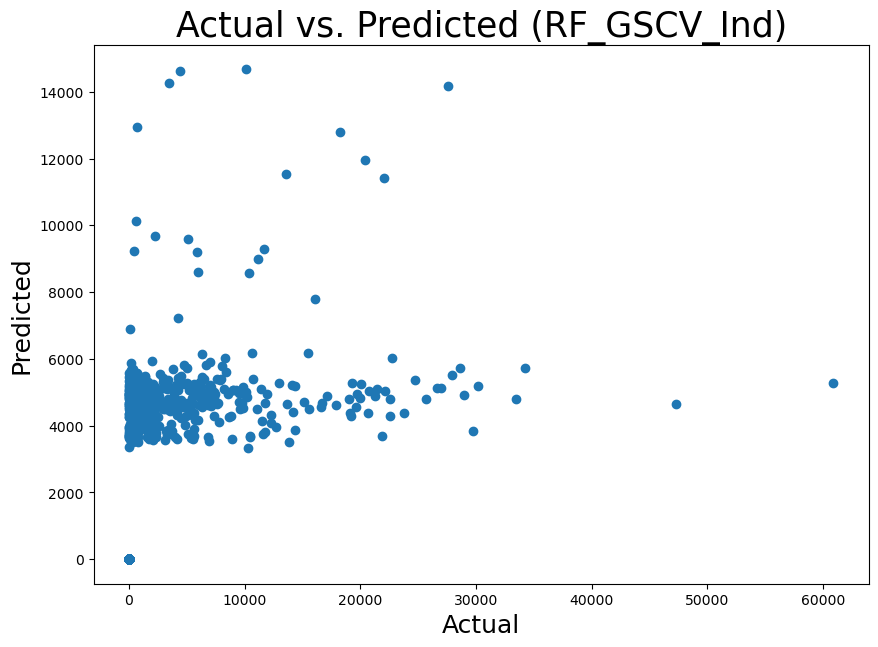

In [91]:
# Define the parameter grid for GridSearchCV
param_grid_RF_GSCV = {
    'regressor__n_estimators': [10, 20, 3000],  # Number of trees in the forest
    'regressor__max_depth': [None, 5],  # Maximum depth of the tree
    'regressor__min_samples_split': [5, 10],  # Minimum number of samples required to split a node
    'regressor__min_samples_leaf': [1, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model for GridSearchCV
rf_model_RF_GSCV = RandomForestRegressor(random_state=42)

# Create Pipeline for Random Forest with preprocessing and GridSearchCV
pipeline_RF_GSCV = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('regressor', rf_model_RF_GSCV)  # Random Forest regressor
])

# Configuration et exécution de la recherche sur grille
grid_search_RF_GSCV = GridSearchCV(estimator=pipeline_RF_GSCV, param_grid=param_grid_RF_GSCV, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_RF_GSCV.fit(X_train_Ind, y_train_Ind)

best_rf_model_RF_GSCV = grid_search_RF_GSCV.best_estimator_

# Make predictions
y_pred_rf_grid_Ind = best_rf_model_RF_GSCV.predict(X_test_Ind)

# Evaluate the model
mse_rf_grid_Ind = mean_squared_error(y_test_Ind, y_pred_rf_grid_Ind)
print("Random Forest Regression Metrics (with GridSearchCV) (RF_GSCV_Ind):")
print(f"Mean Squared Error (RF_GSCV_Ind): {mse_rf_grid_Ind}")

r2_rf_grid_Ind = r2_score(y_test_Ind, y_pred_rf_grid_Ind)
print(f"R-squared Score (RF_GSCV_Ind): {r2_rf_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV (RF_GSCV_Ind):")
print(grid_search_RF_GSCV.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_absolute_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mean_absolute_error(y_test_Ind, y_pred_rf_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", mse_rf_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind))))
print("Test_RF_GSCV_Ind:", np.sqrt(mse_rf_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", r2_score(y_train_Ind, best_rf_model_RF_GSCV.predict(X_train_Ind)))
print("Test_RF_GSCV_Ind:", r2_rf_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_Ind = np.mean(np.abs((y_train_Ind - best_rf_model_RF_GSCV.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (RF_GSCV_Ind):")
print("Train_RF_GSCV_Ind:", mape_train_rf_Ind)
print("Test_RF_GSCV_Ind:", np.mean(np.abs((y_test_Ind - y_pred_rf_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (RF_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_rf_grid_Ind)
plt.show()

#### 5. XGBoost with GridSearch

XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:
Mean Squared Error (xgb_GSCV_Ind): 2365049.518198713
R-squared Score (xgb_GSCV_Ind): 0.34374922700905763
Best parameters found by GridSearchCV:
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 900}
MAE (xgb_GSCV_Ind):
Train_Ind: 216.75192291061072
Test_Ind: 220.3691301431373
MSE (xgb_GSCV_Ind):
Train_Ind: 2286202.475711111
Test_Ind: 2365049.518198713
RMSE (xgb_GSCV_Ind):
Train_Ind: 1512.0193370824036
Test_Ind: 1537.8717495938058
R2 SCORE (xgb_GSCV_Ind):
Train_Ind: 0.3358958567407956
Test_Ind: 0.34374922700905763
MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):
Train_Ind: inf
Test_Ind: inf


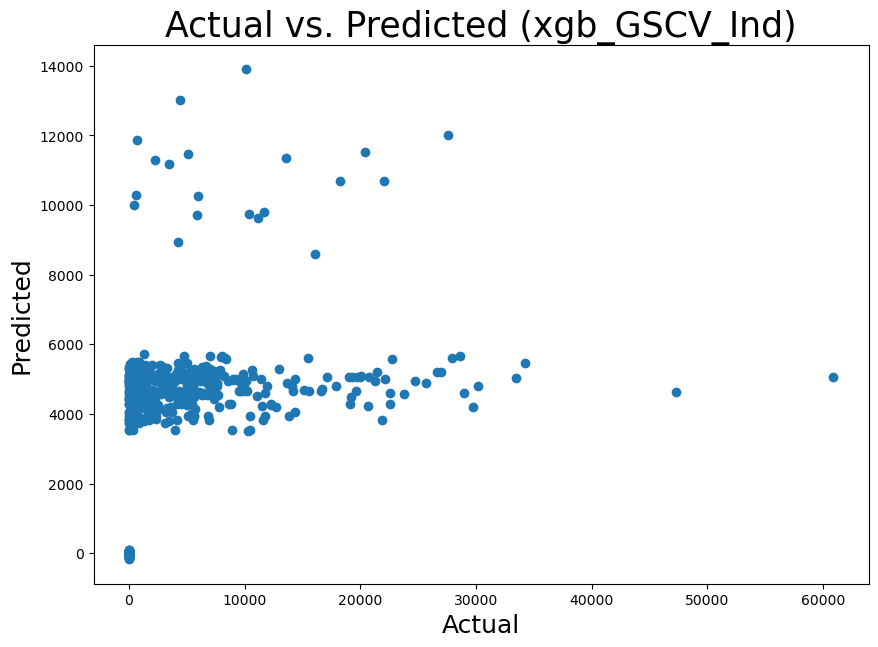

In [101]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_Ind, y_train_Ind)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_Ind = best_xgb_model.predict(X_test_Ind)

# Evaluate the model
mse_xgb_grid_Ind = mean_squared_error(y_test_Ind, y_pred_xgb_grid_Ind)
print("XGBoost Regression Metrics (with GridSearchCV) - xgb_GSCV_Ind:")
print(f"Mean Squared Error (xgb_GSCV_Ind): {mse_xgb_grid_Ind}")

r2_xgb_grid_Ind = r2_score(y_test_Ind, y_pred_xgb_grid_Ind)
print(f"R-squared Score (xgb_GSCV_Ind): {r2_xgb_grid_Ind}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_absolute_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mean_absolute_error(y_test_Ind, y_pred_xgb_grid_Ind))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE (xgb_GSCV_Ind):")
print("Train_Ind:", mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", mse_xgb_grid_Ind)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE (xgb_GSCV_Ind):")
print("Train_Ind:", np.sqrt(mean_squared_error(y_train_Ind, best_xgb_model.predict(X_train_Ind))))
print("Test_Ind:", np.sqrt(mse_xgb_grid_Ind))
print("====================================")

# Print R2 SCORE
print("R2 SCORE (xgb_GSCV_Ind):")
print("Train_Ind:", r2_score(y_train_Ind, best_xgb_model.predict(X_train_Ind)))
print("Test_Ind:", r2_xgb_grid_Ind)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_Ind = np.mean(np.abs((y_train_Ind - best_xgb_model.predict(X_train_Ind)) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (xgb_GSCV_Ind):")
print("Train_Ind:", mape_train_xgb_Ind)
print("Test_Ind:", np.mean(np.abs((y_test_Ind - y_pred_xgb_grid_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (xgb_GSCV_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=y_pred_xgb_grid_Ind)
plt.show()

#### 6. MLP Regressor

MAE (MLP_Ind):
Train_MLP_Ind: 228.01614268733488
Test_MLP_Ind: 236.26600341405808
MSE (MLP_Ind):
Train_MLP_Ind: 2178431.0130306743
Test_MLP_Ind: 2421371.128989063
RMSE (MLP_Ind):
Train_MLP_Ind: 1475.9508843558021
Test_MLP_Ind: 1556.0755537534362
R2 SCORE (MLP_Ind):
Train_MLP_Ind: 0.3672016906079033
Test_MLP_Ind: 0.3281211818739127
MAPE - Mean Absolute Percentage Error (MLP_Ind):
Train_MLP_Ind: inf
Test_MLP_Ind: inf


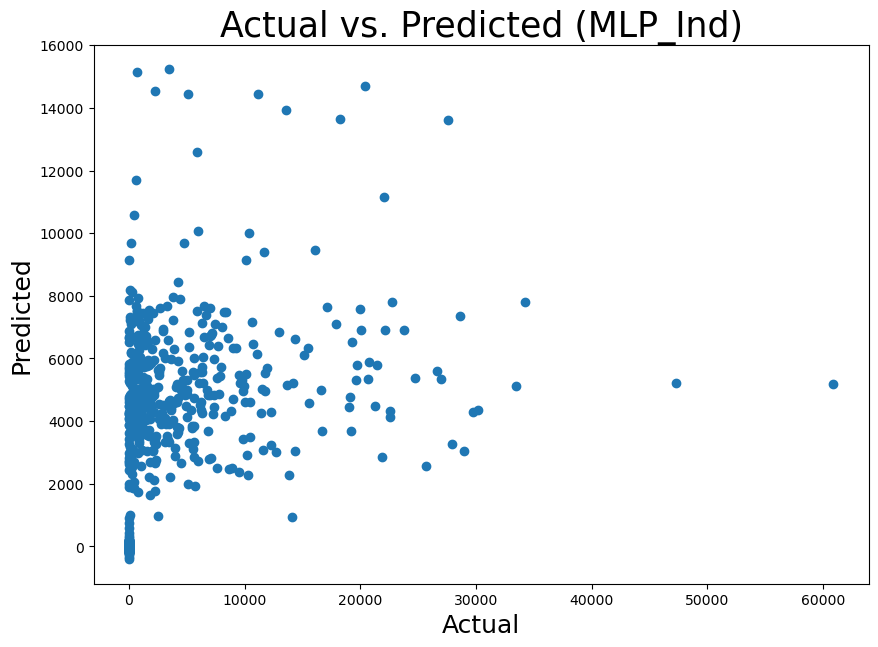

In [102]:
# Define the MLP regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                             alpha=0.0001, batch_size='auto', learning_rate='constant', 
                             learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                             random_state=42, tol=0.0001, verbose=False, warm_start=False, 
                             momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                             validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                             n_iter_no_change=10, max_fun=15000)

# Fit the MLP regressor
mlp_regressor.fit(X_train_Ind, y_train_Ind)

# Make predictions
train_predict_mlp_Ind = mlp_regressor.predict(X_train_Ind)
test_predict_mlp_Ind = mlp_regressor.predict(X_test_Ind)

# Print evaluation metrics
print("MAE (MLP_Ind):")
print("Train_MLP_Ind:", mean_absolute_error(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", mean_absolute_error(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

print("MSE (MLP_Ind):")
print("Train_MLP_Ind:", mean_squared_error(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", mean_squared_error(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

print("RMSE (MLP_Ind):")
print("Train_MLP_Ind:", np.sqrt(mean_squared_error(y_train_Ind, train_predict_mlp_Ind)))
print("Test_MLP_Ind:", np.sqrt(mean_squared_error(y_test_Ind, test_predict_mlp_Ind)))
print("====================================")

print("R2 SCORE (MLP_Ind):")
print("Train_MLP_Ind:", r2_score(y_train_Ind, train_predict_mlp_Ind))
print("Test_MLP_Ind:", r2_score(y_test_Ind, test_predict_mlp_Ind))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_mlp_Ind = np.mean(np.abs((y_train_Ind - train_predict_mlp_Ind) / y_train_Ind)) * 100
print("MAPE - Mean Absolute Percentage Error (MLP_Ind):")
print("Train_MLP_Ind:", mape_train_mlp_Ind)
print("Test_MLP_Ind:", np.mean(np.abs((y_test_Ind - test_predict_mlp_Ind) / y_test_Ind)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (MLP_Ind)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test_Ind, y=test_predict_mlp_Ind)
plt.show()

#### Step B. Predicting the Primepbi : 

#### 1. Linear Regression

Intercept (reg_lin_model): 54.28788565946586
Coefficients (reg_lin_model): [-1.93579510e-01 -2.78765026e-01  3.87816948e-01 -4.91854227e-01
 -1.57695844e-01  9.69756771e+00  2.60356765e-01 -7.42856102e-01
  4.14585935e+02  3.36004494e-01  9.55737425e-01 -1.10556803e-01
 -6.11767910e-01 -1.43967337e-01 -4.25449869e-01 -4.55438515e-01
  1.37030514e+00  4.85765427e-01 -1.78781533e+00  3.87183271e-01
  4.02234709e-01  3.67039566e-02 -4.38938666e-01 -2.76098212e-01
  2.76098212e-01]
MAE_reg_lin_model:
Train_reg_lin_model: 5.966818748580545
Test_reg_lin_model: 7.347322410908489
MSE_reg_lin_model:
Train_reg_lin_model: 5456.820868666718
Test_reg_lin_model: 8858.640481011507
RMSE_reg_lin_model:
Train_reg_lin_model: 73.87029760781202
Test_reg_lin_model: 94.12035104594281
R2_SCORE_reg_lin_model:
Train_reg_lin_model: 0.97003499977725
Test_reg_lin_model: 0.9580690596427015
MAPE_reg_lin_model - Mean Absolute Percentage Error:
Train_reg_lin_model: inf
Test_reg_lin_model: inf


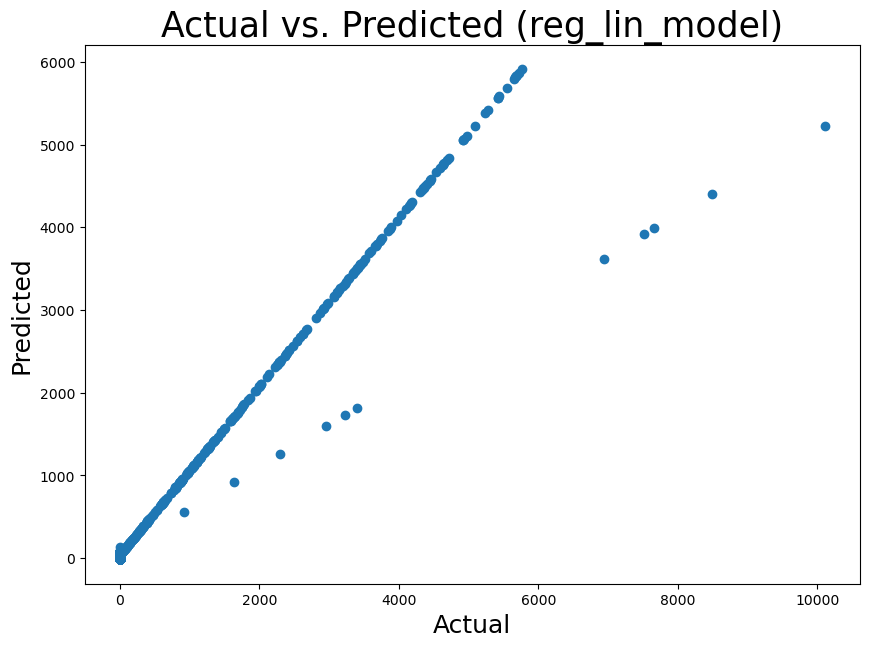

In [173]:
# Instantiate the Linear Regression model
reg_lin_model = LinearRegression()

# Fit the model on the training data
reg_lin_model.fit(X_train, y_train)

# Print intercept and coefficients
print("Intercept (reg_lin_model):", reg_lin_model.intercept_)
print("Coefficients (reg_lin_model):", reg_lin_model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin = reg_lin_model.predict(X_train)
test_predict_reg_lin = reg_lin_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_model:")
print("Train_reg_lin_model:", mean_absolute_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_absolute_error(y_test, test_predict_reg_lin))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_model:")
print("Train_reg_lin_model:", mean_squared_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_squared_error(y_test, test_predict_reg_lin))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_model:")
print("Train_reg_lin_model:", np.sqrt(mean_squared_error(y_train, train_predict_reg_lin)))
print("Test_reg_lin_model:", np.sqrt(mean_squared_error(y_test, test_predict_reg_lin)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_model:")
print("Train_reg_lin_model:", r2_score(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", r2_score(y_test, test_predict_reg_lin))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin, train_predict_reg_lin = np.array(y_train), np.array(train_predict_reg_lin)
mape_train_reg_lin = np.mean(np.abs((train_y_reg_lin - train_predict_reg_lin) / train_y_reg_lin)) * 100
print("MAPE_reg_lin_model - Mean Absolute Percentage Error:")
print("Train_reg_lin_model:", mape_train_reg_lin)
print("Test_reg_lin_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_reg_lin)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_reg_lin)
plt.show()


#### 2. Polynomial Features

Polynomial Regression Metrics:
Mean Squared Error: 3.4684631132329195e-25
R-squared Score: 1.0
Intercept (poly_model): -252.48908029940011
Coefficients (poly_model): [ 3.81630329e-03 -1.03584099e+00  5.85068924e+00  1.20605040e-01
 -9.85154987e-02  7.75253632e-01  5.29295729e+00 -9.53215965e+00
 -5.57562947e+00  7.49576624e+00  8.47760205e-03 -5.28550359e-02
  4.92103529e-02 -3.29972469e-02 -9.05229242e-02 -2.20118374e-02
 -7.09787161e-03  5.62644194e-02 -8.93402629e-03  7.71168898e-02
  5.49486279e-02 -4.64311357e-03  1.16317865e-01 -4.45494684e-02
  2.13155861e-02 -2.12637668e-02  2.13162821e-14  7.10542736e-15
  1.06581410e-14  2.48689958e-14  1.55431223e-15 -3.19744231e-14
  2.30926389e-14  3.90798505e-14 -3.90798505e-14 -1.60071150e-01
 -1.60071150e-01 -1.60071150e-01 -1.60071150e-01 -1.60071150e-01
 -1.60071150e-01  7.35288064e-01  7.35288064e-01  7.35288064e-01
  7.35288064e-01  7.35288064e-01  7.95526373e-01  7.95526373e-01
  7.95526373e-01 -3.34902300e-01 -3.34902300e-01  2.54

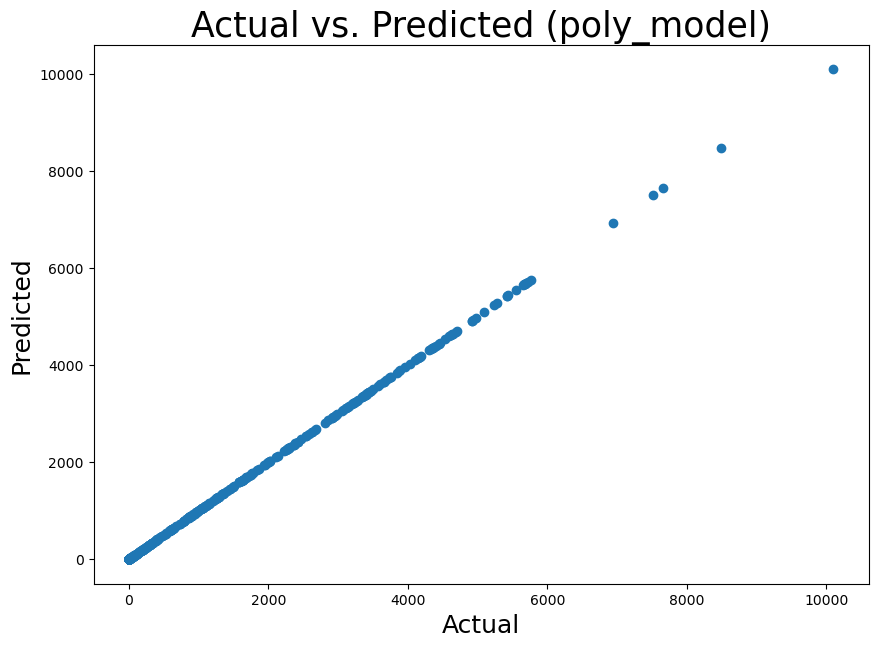

NameError: name 'ow' is not defined

In [174]:
# Define the polynomial regression model
degree = 2  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("Polynomial Regression Metrics:")
print(f"Mean Squared Error: {mse_poly}")

r2_poly = r2_score(y_test, y_pred_poly)
print(f"R-squared Score: {r2_poly}")

# Calculate other metrics
print("Intercept (poly_model):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_model):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly = poly_model.predict(X_train)
test_predict_poly = poly_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_poly_model:")
print("Train_poly_model:", mean_absolute_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_absolute_error(y_test, test_predict_poly))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_poly_model:")
print("Train_poly_model:", mean_squared_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_squared_error(y_test, test_predict_poly))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_poly_model:")
print("Train_poly_model:", np.sqrt(mean_squared_error(y_train, train_predict_poly)))
print("Test_poly_model:", np.sqrt(mean_squared_error(y_test, test_predict_poly)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_poly_model:")
print("Train_poly_model:", r2_score(y_train, train_predict_poly))
print("Test_poly_model:", r2_score(y_test, test_predict_poly))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_poly, train_predict_poly = np.array(y_train), np.array(train_predict_poly)
mape_train_poly = np.mean(np.abs((train_y_poly - train_predict_poly) / train_y_poly)) * 100
print("MAPE_poly_model - Mean Absolute Percentage Error:")
print("Train_poly_model:", mape_train_poly)
print("Test_poly_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_poly)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_poly)
plt.show()



#### 3. SVR

SVR Regression Metrics:
Mean Squared Error (svr_model): 9417.553001439604
R-squared Score (svr_model): 0.9554235377243832
MAE_svr_model:
Train_svr_model: 1.6206549145590217
Test_svr_model: 2.8542857444400327
MSE_svr_model:
Train_svr_model: 5694.51646346309
Test_svr_model: 9417.553001439604
RMSE_svr_model:
Train_svr_model: 75.46202000651115
Test_svr_model: 97.0440776216643
R2_SCORE_svr_model:
Train_svr_model: 0.9687297437092127
Test_svr_model: 0.9554235377243832
MAPE_svr_model - Mean Absolute Percentage Error:
Train_svr_model: inf
Test_svr_model: inf


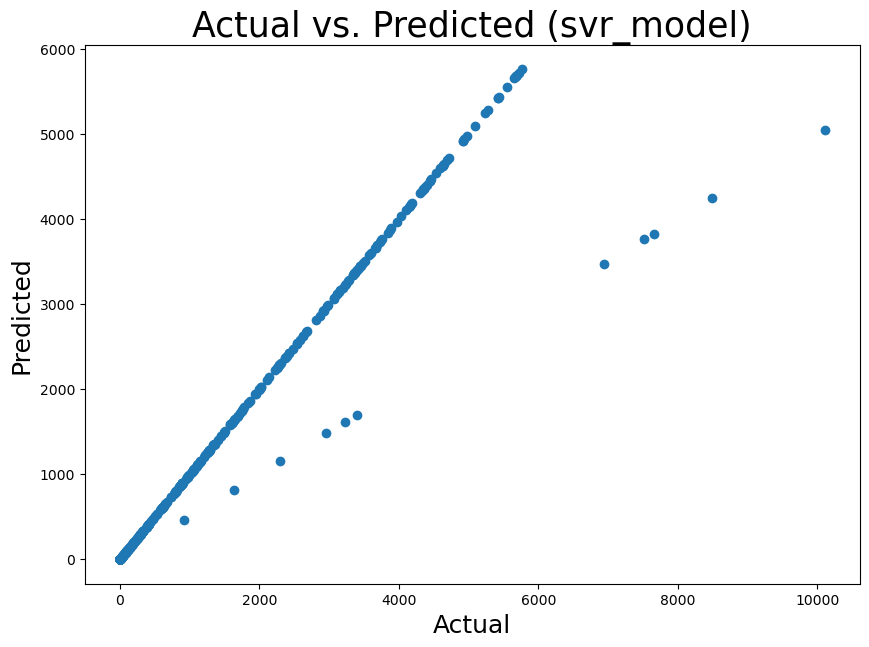

In [175]:

# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
print("SVR Regression Metrics:")
print(f"Mean Squared Error (svr_model): {mse_svr}")

r2_svr = r2_score(y_test, y_pred_svr)
print(f"R-squared Score (svr_model): {r2_svr}")

# Predicting on TRAIN & TEST DATA
train_predict_svr = svr_model.predict(X_train)
test_predict_svr = svr_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_svr_model:")
print("Train_svr_model:", mean_absolute_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_absolute_error(y_test, test_predict_svr))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_svr_model:")
print("Train_svr_model:", mean_squared_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_squared_error(y_test, test_predict_svr))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_svr_model:")
print("Train_svr_model:", np.sqrt(mean_squared_error(y_train, train_predict_svr)))
print("Test_svr_model:", np.sqrt(mean_squared_error(y_test, test_predict_svr)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_svr_model:")
print("Train_svr_model:", r2_score(y_train, train_predict_svr))
print("Test_svr_model:", r2_score(y_test, test_predict_svr))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_svr, train_predict_svr = np.array(y_train), np.array(train_predict_svr)
mape_train_svr = np.mean(np.abs((train_y_svr - train_predict_svr) / train_y_svr)) * 100
print("MAPE_svr_model - Mean Absolute Percentage Error:")
print("Train_svr_model:", mape_train_svr)
print("Test_svr_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_svr)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_svr)
plt.show()

#### 4. RandomForest with Grid Search

Random Forest Regression Metrics (with GridSearchCV):
Mean Squared Error (rf_grid_model): 131.13929043980883
R-squared Score (rf_grid_model): 0.9993792734023108
Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE_rf_grid_model:
Train_rf_grid_model: 0.11276143858144012
Test_rf_grid_model: 0.35572151418412606
MSE_rf_grid_model:
Train_rf_grid_model: 42.43505899834571
Test_rf_grid_model: 131.13929043980883
RMSE_rf_grid_model:
Train_rf_grid_model: 6.514219753611764
Test_rf_grid_model: 11.451606456729502
R2_SCORE_rf_grid_model:
Train_rf_grid_model: 0.9997669766732422
Test_rf_grid_model: 0.9993792734023108
MAPE_rf_grid_model - Mean Absolute Percentage Error:
Train_rf_grid_model: inf
Test_rf_grid_model: inf


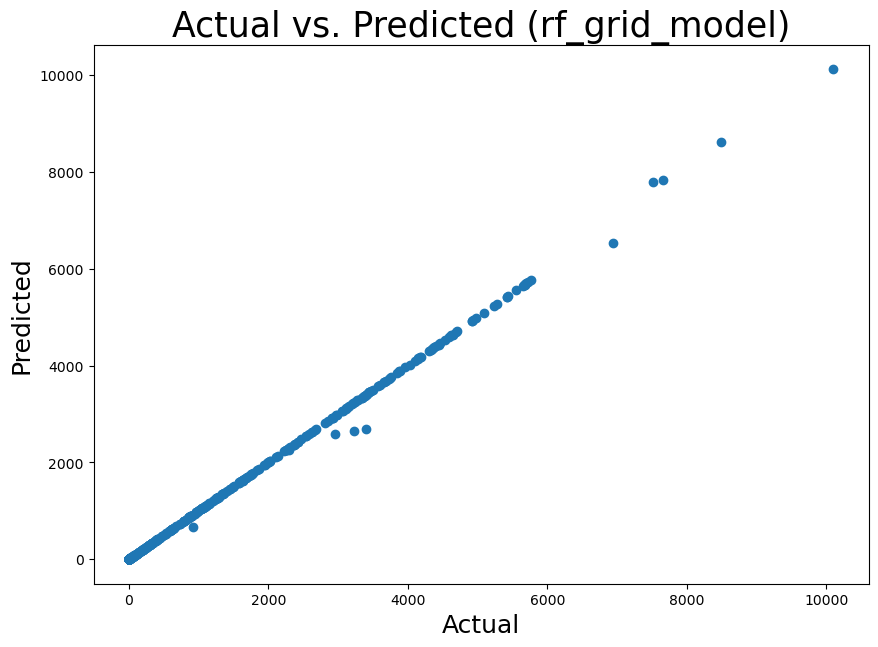

In [177]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_rf_grid_model = best_rf_model.predict(X_test)

# Evaluate the model
mse_rf_grid_model = mean_squared_error(y_test, y_pred_rf_grid_model)
print("Random Forest Regression Metrics (with GridSearchCV):")
print(f"Mean Squared Error (rf_grid_model): {mse_rf_grid_model}")

r2_rf_grid_model = r2_score(y_test, y_pred_rf_grid_model)
print(f"R-squared Score (rf_grid_model): {r2_rf_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_rf_grid_model:")
print("Train_rf_grid_model:", mean_absolute_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mean_absolute_error(y_test, y_pred_rf_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_grid_model:")
print("Train_rf_grid_model:", mean_squared_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mse_rf_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_grid_model:")
print("Train_rf_grid_model:", np.sqrt(mean_squared_error(y_train, best_rf_model.predict(X_train))))
print("Test_rf_grid_model:", np.sqrt(mse_rf_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_grid_model:")
print("Train_rf_grid_model:", r2_score(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", r2_rf_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_grid_model = np.mean(np.abs((y_train - best_rf_model.predict(X_train)) / y_train)) * 100
print("MAPE_rf_grid_model - Mean Absolute Percentage Error:")
print("Train_rf_grid_model:", mape_train_rf_grid_model)
print("Test_rf_grid_model:", np.mean(np.abs((y_test - y_pred_rf_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_grid_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_rf_grid_model)
plt.show()

#### 5. XGBoost with Grid Search

XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):
Mean Squared Error (best_xgb_model_grid): 30.890870700526488
R-squared Score (best_xgb_model_grid): 0.9998537830652791
Best parameters found by GridSearchCV:
{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 900}
MAE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.21989925113622488
Test_best_xgb_model_grid: 0.40663706915187026
MSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 3.4510021298256666
Test_best_xgb_model_grid: 30.890870700526488
RMSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 1.857687306794571
Test_best_xgb_model_grid: 5.557955622396286
R2_SCORE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.9999810495374362
Test_best_xgb_model_grid: 0.9998537830652791
MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:
Train_best_xgb_model_grid: inf
Test_best_xgb_model_grid: inf


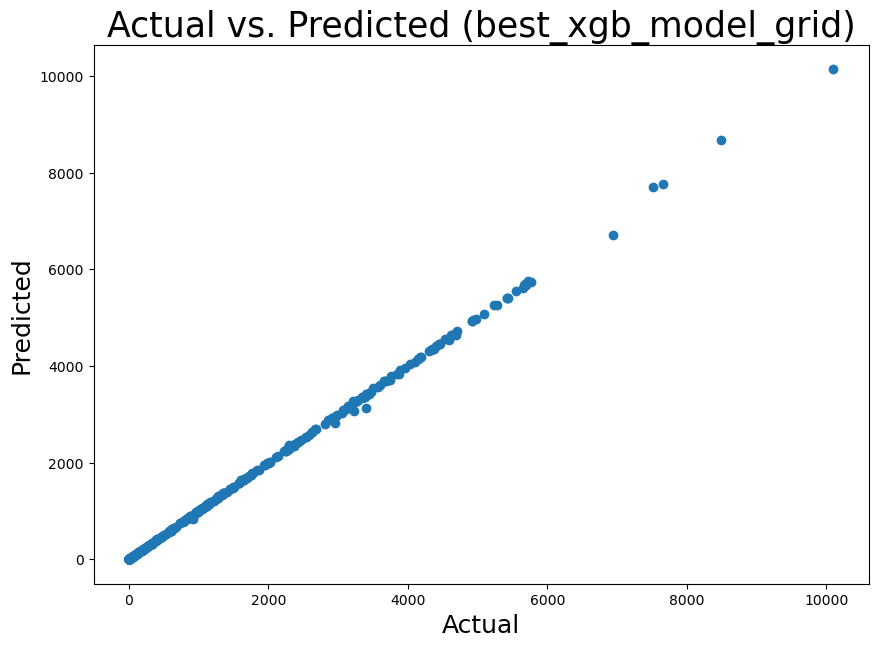

In [200]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model_grid = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_model = best_xgb_model_grid.predict(X_test)

# Evaluate the model
mse_xgb_grid_model = mean_squared_error(y_test, y_pred_xgb_grid_model)
print("XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):")
print(f"Mean Squared Error (best_xgb_model_grid): {mse_xgb_grid_model}")

r2_xgb_grid_model = r2_score(y_test, y_pred_xgb_grid_model)
print(f"R-squared Score (best_xgb_model_grid): {r2_xgb_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_absolute_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mean_absolute_error(y_test, y_pred_xgb_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_squared_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mse_xgb_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", np.sqrt(mean_squared_error(y_train, best_xgb_model_grid.predict(X_train))))
print("Test_best_xgb_model_grid:", np.sqrt(mse_xgb_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", r2_score(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", r2_xgb_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_grid_model = np.mean(np.abs((y_train - best_xgb_model_grid.predict(X_train)) / y_train)) * 100
print("MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:")
print("Train_best_xgb_model_grid:", mape_train_xgb_grid_model)
print("Test_best_xgb_model_grid:", np.mean(np.abs((y_test - y_pred_xgb_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (best_xgb_model_grid)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_grid_model)
plt.show()


#### Step 4. Interpretability

#### Step A: Predicting IndtPBI

In [106]:
# List of model names
model_names = ['SVR', 'Linear Regression', 'Polynomial Regression', 'Random Forest With GridSearch', 'XGBoost With GridSearch', 'MLP Regressor']

# List of predicted values for each model
all_y_pred = [test_predict_svr_Ind, test_predict_reg_lin_Ind, test_predict_poly_Ind, y_pred_rf_grid_Ind, y_pred_xgb_grid_Ind, test_predict_mlp_Ind]

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_test_Ind, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_test_Ind, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_test_Ind, y_pred) for y_pred in all_y_pred]
}

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)



Predictions DataFrame:


,y_pred_SVR,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_Random Forest With GridSearch,y_pred_XGBoost With GridSearch,y_pred_MLP Regressor
0,0.099885,-15.276376,358.147461,0.0,21.271309,25.039351
1,0.099557,-82.668626,-226.884888,0.0,-2.960001,4.790584
2,0.099612,-8.007842,64.418213,0.0,-2.370580,-9.556500
3,0.099975,-1.372974,-98.798950,0.0,6.068972,4.019674
4,0.100083,10.248823,39.613770,0.0,-1.491472,-17.907558
...,...,...,...,...,...,...
9993,0.099952,34.148656,-24.984375,0.0,1.360184,-48.446494
9994,-0.099935,7.247209,-86.709229,0.0,-2.001645,-14.196540
9995,0.099952,80.503920,-206.975098,0.0,11.823467,-14.830437
9996,-0.099739,130.012394,-1479.604858,0.0,-62.535652,104.469017


In [107]:
print("\nMetrics DataFrame:")
df_metrics


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,SVR,198.019157,2.832193e+06,1682.912116,0.214127
1,Linear Regression,253.214485,2.387127e+06,1545.033159,0.337623
2,Polynomial Regression,349.718324,2.595124e+06,1610.938946,0.279908
3,Random Forest With GridSearch,214.714026,2.356938e+06,1535.232289,0.346000
4,XGBoost With GridSearch,220.369130,2.365050e+06,1537.871750,0.343749
5,MLP Regressor,236.266003,2.421371e+06,1556.075554,0.328121


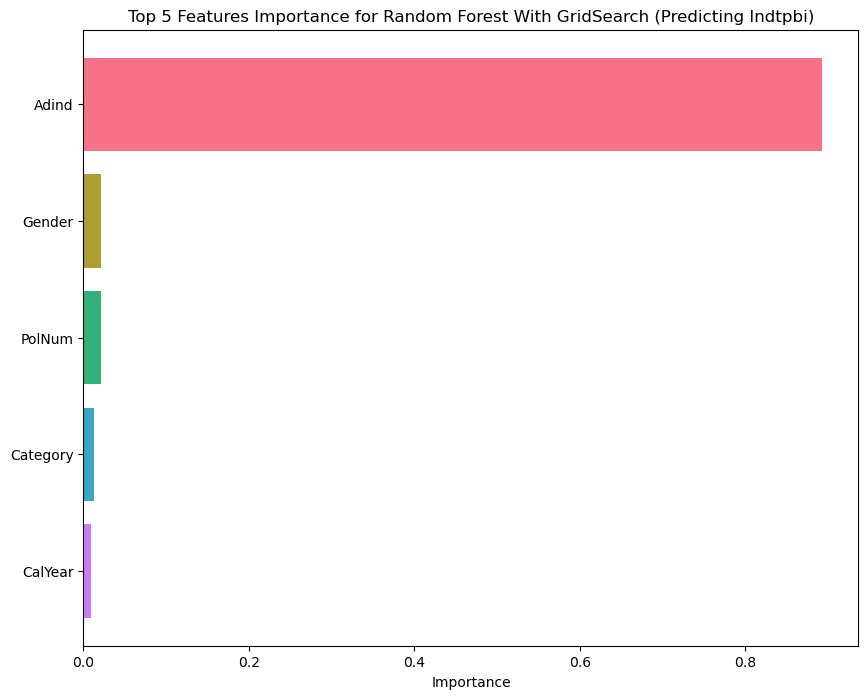

In [134]:
# Retrieve the best estimator
best_rf_model = grid_search_RF_GSCV.best_estimator_
feature_importances = best_rf_model.feature_importances_

# List of feature names
feature_names = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus_processed', 'Exppdays',
                     'Numtpbi', 'Indtppd_processed', 'Numtppd']

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)

# Select the top 5 most important features
top_5_idx = sorted_idx[-5:]

# Define your custom color palette
custom_palette = sns.color_palette("husl", 5) 

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(5), feature_importances[top_5_idx][::-1], color=custom_palette)
plt.yticks(range(5), np.array(feature_names)[top_5_idx][::-1])  # Reverse the order for display
plt.xlabel('Importance')
plt.title('Top 5 Features Importance for Random Forest With GridSearch (Predicting Indtpbi)')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

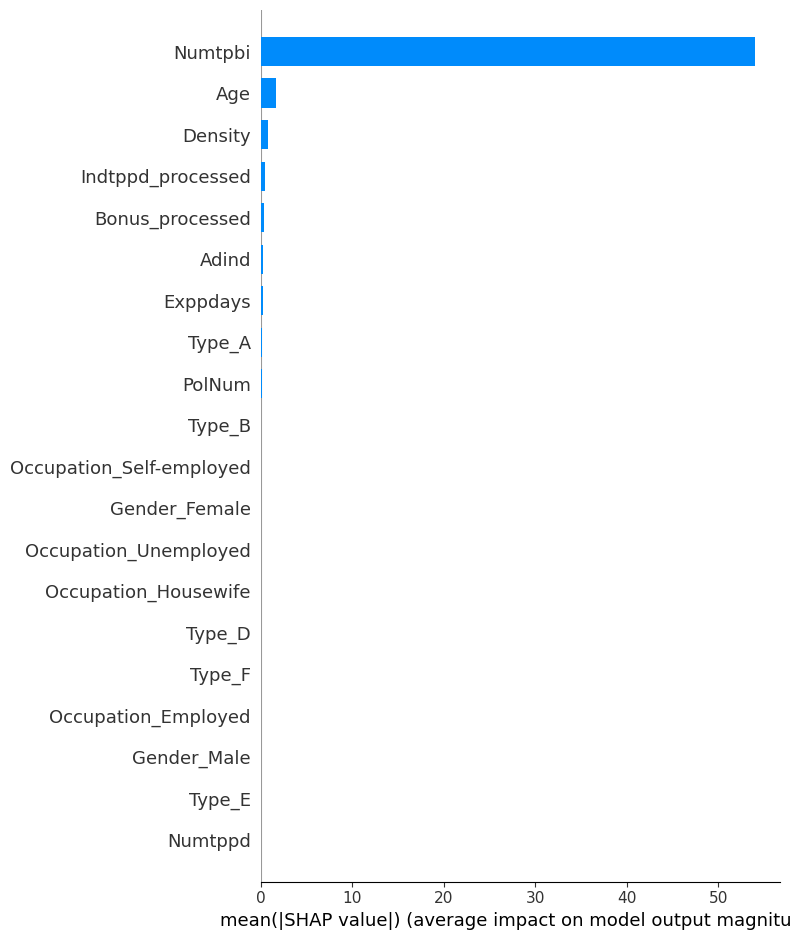

In [118]:
# Explainability with SHAP

# One-hot encode categorical features
X_Ind_encoded = pd.get_dummies(X_Ind)

# Convert DataFrame to NumPy array
X_Ind_encoded_array = X_Ind_encoded.values

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_Ind_encoded_array)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_Ind_encoded_array, plot_type="bar", feature_names=X_Ind_encoded.columns)


In [125]:
# Create a DataFrame of SHAP values with feature names
shap_df = pd.DataFrame(shap_values, columns=X_Ind_encoded.columns)

# Display the DataFrame
shap_df.head()


,PolNum,CalYear,Age,Adind,Density,Bonus_processed,Exppdays,Numtpbi,Indtppd_processed,Numtppd,...,Type_E,Type_F,Category_Large,Category_Medium,Category_Small,Occupation_Employed,Occupation_Housewife,Occupation_Retired,Occupation_Self-employed,Occupation_Unemployed
0,0.083411,-0.011749,1.807248,-0.210613,-0.826304,0.520296,-0.232294,-53.832245,0.044970,-0.108713,...,0.006698,-0.021402,0.039726,-0.010027,-0.004569,0.063826,-0.030671,0.002065,0.053377,-0.019113
1,0.018977,-0.011749,1.868747,-0.198675,-0.823105,0.540168,-0.231682,-53.773499,0.050213,-0.097239,...,-0.063846,-0.021424,0.038947,-0.008969,-0.008537,0.064960,-0.031484,0.002059,0.053583,-0.019979
2,-0.162182,-0.011591,1.804670,-0.216131,-0.709555,0.370740,-0.218190,-53.618672,0.025378,-0.095112,...,-0.130059,-0.023033,0.031230,-0.003541,-0.008999,-0.021128,-0.027221,0.002259,0.050706,0.159992
3,-0.106553,-0.011066,1.512688,-0.216785,-0.837799,-0.277817,-0.214301,-52.630102,0.017405,-0.107258,...,0.015286,-0.022821,-0.015337,0.017040,-0.004038,-0.023220,0.087451,0.002167,0.055202,-0.020199
4,0.236472,-0.011468,1.939556,-0.223802,-0.763831,0.501965,-0.243606,-54.173298,0.049588,-0.118492,...,0.006996,-0.021796,0.040049,-0.006047,-0.009570,0.067473,-0.029624,0.002147,0.054881,-0.020026


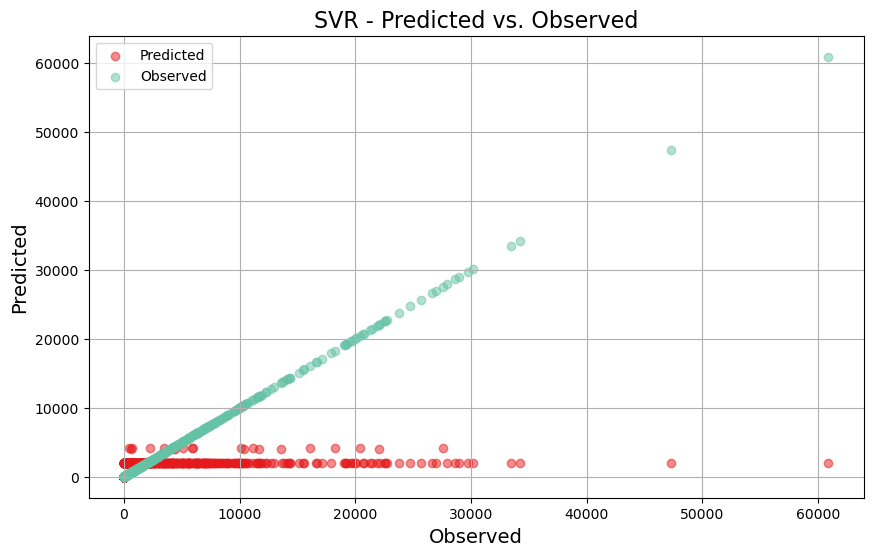

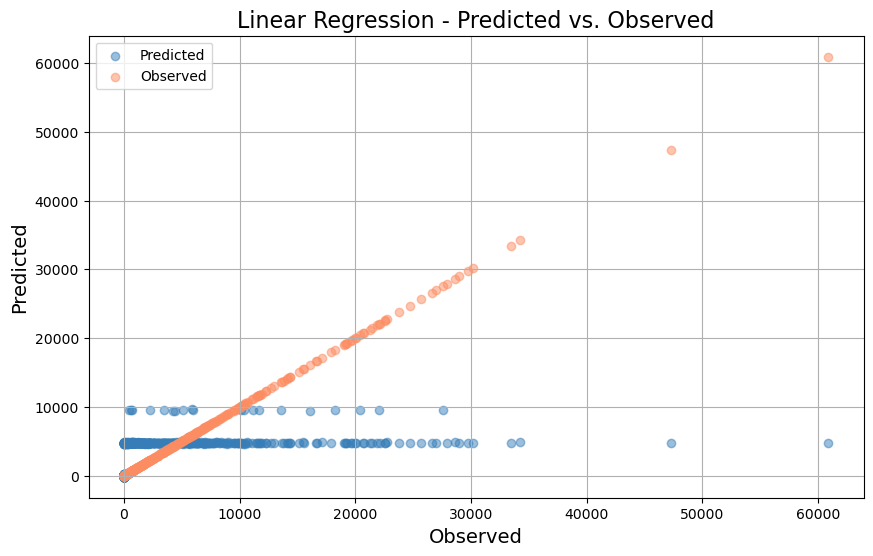

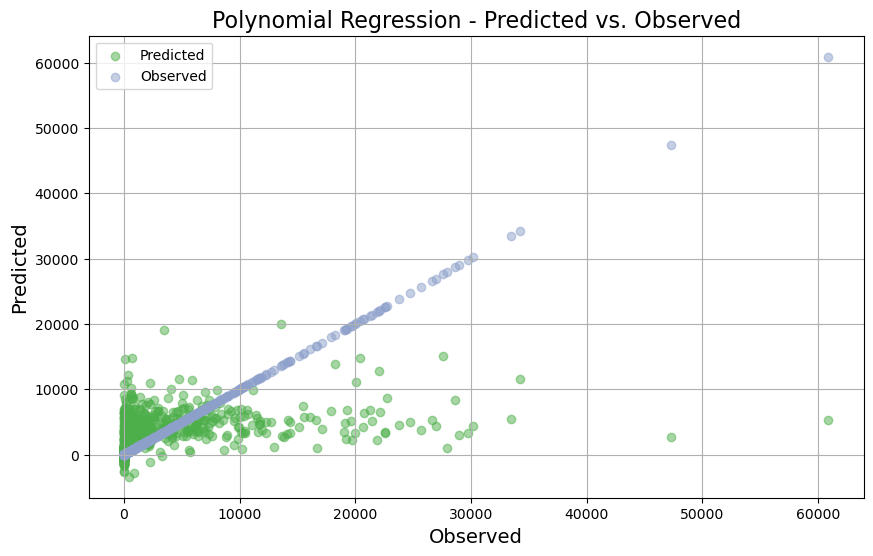

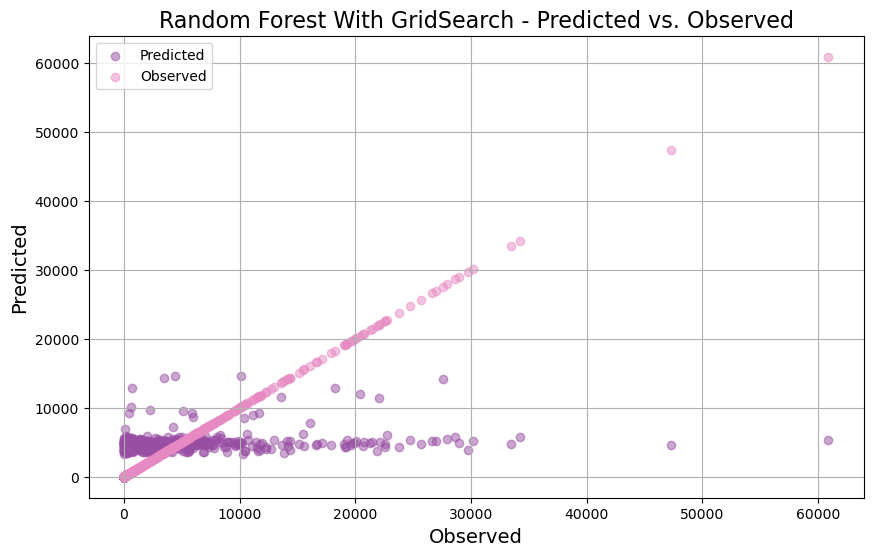

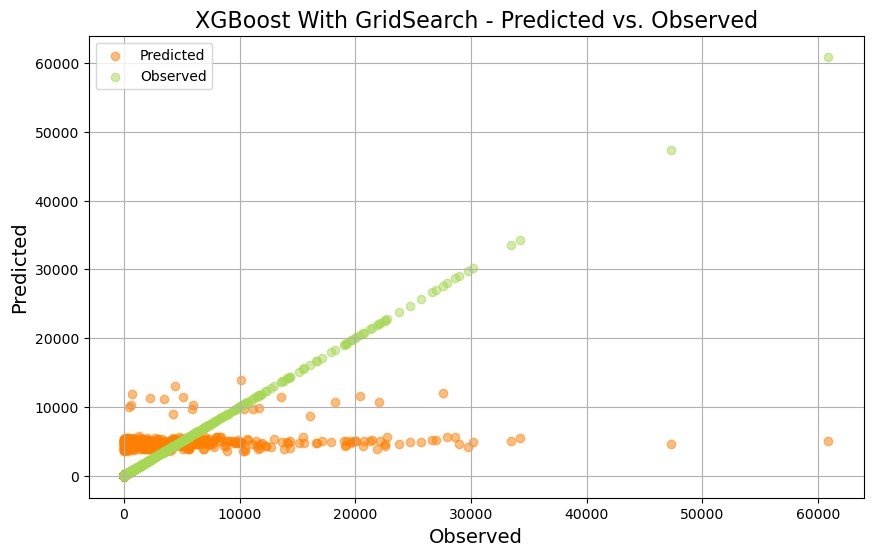

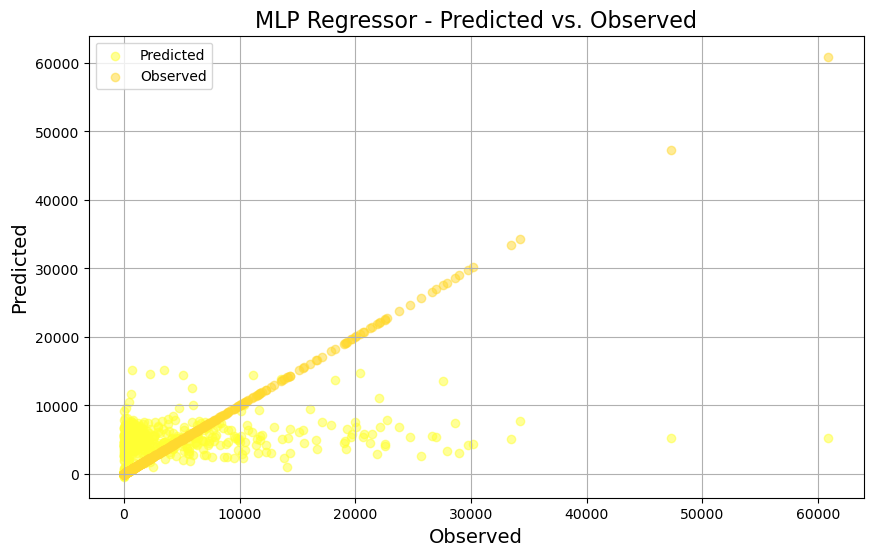

In [130]:
# Define palette of colors
palette_pred = sns.color_palette("Set1", n_colors=len(model_names))
palette_obs = sns.color_palette("Set2", n_colors=len(model_names))

# List of model names
model_names = ['SVR', 'Linear Regression', 'Polynomial Regression', 'Random Forest With GridSearch', 'XGBoost With GridSearch', 'MLP Regressor']

# List of predicted values for each model
all_y_pred = [test_predict_svr_Ind, test_predict_reg_lin_Ind, test_predict_poly_Ind, y_pred_rf_grid_Ind, y_pred_xgb_grid_Ind, test_predict_mlp_Ind]

# Create DataFrame for predictions
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})

# Add observed values to the DataFrame
df_predictions['Observed'] = y_test_Ind.values

# Plotting predictions vs. observed for each model with different colors for predicted and observed values
for i, model in enumerate(model_names):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_predictions['Observed'], df_predictions[f'y_pred_{model}'], alpha=0.5, color=palette_pred[i], label='Predicted')
    plt.scatter(df_predictions['Observed'], df_predictions['Observed'], alpha=0.5, color=palette_obs[i], label='Observed')
    plt.title(f'{model} - Predicted vs. Observed', fontsize=16)
    plt.xlabel('Observed', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

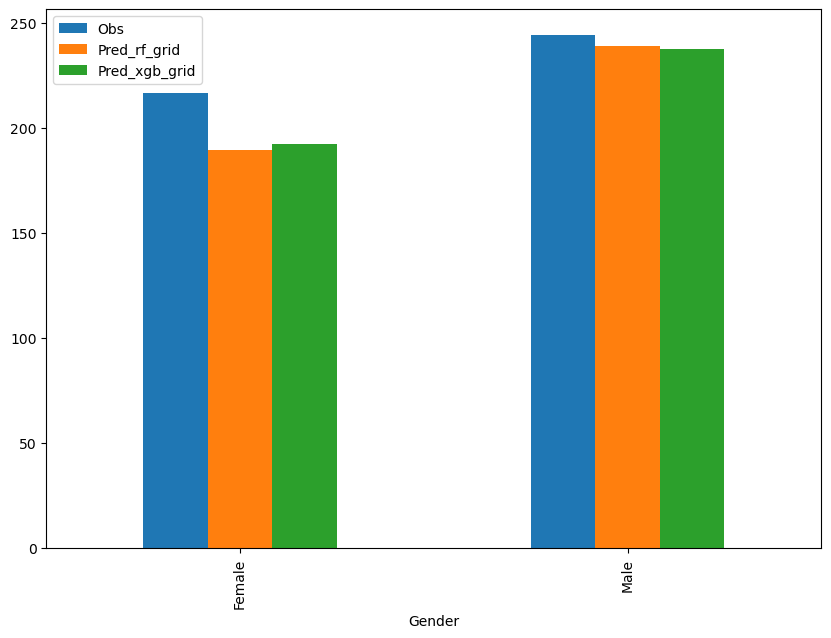

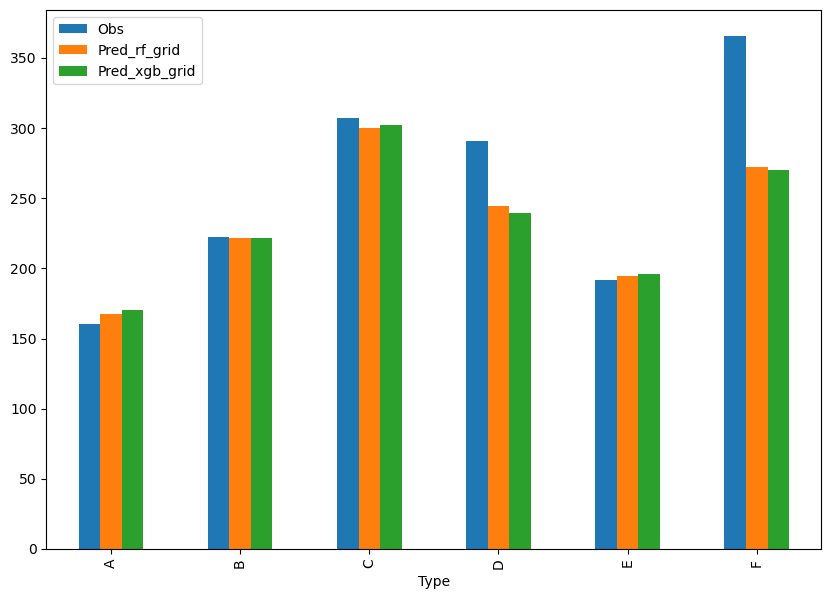

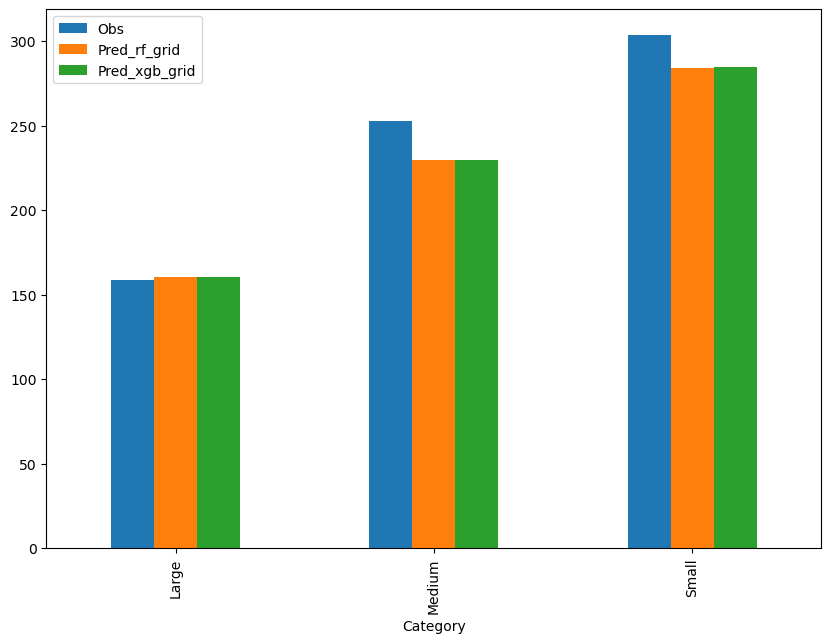

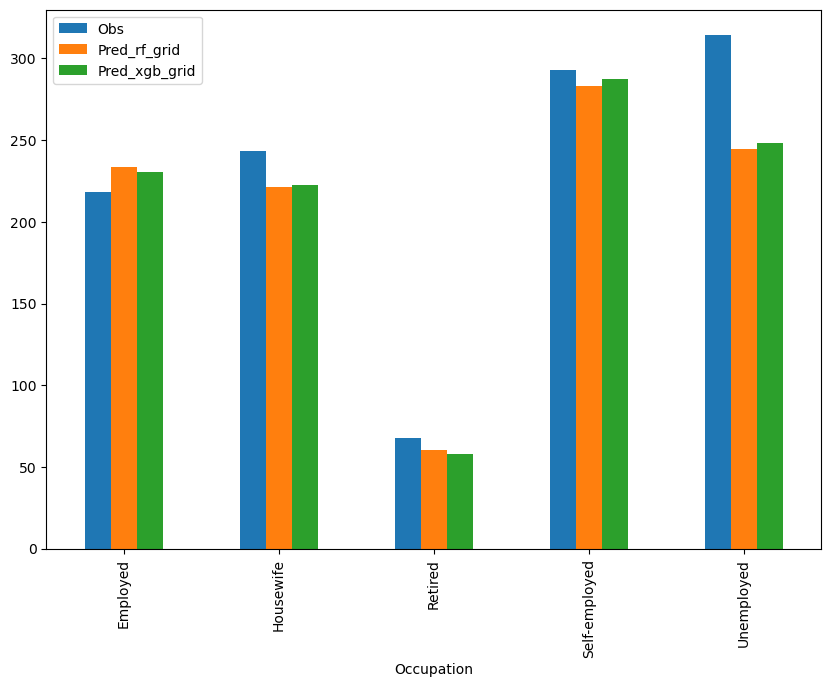

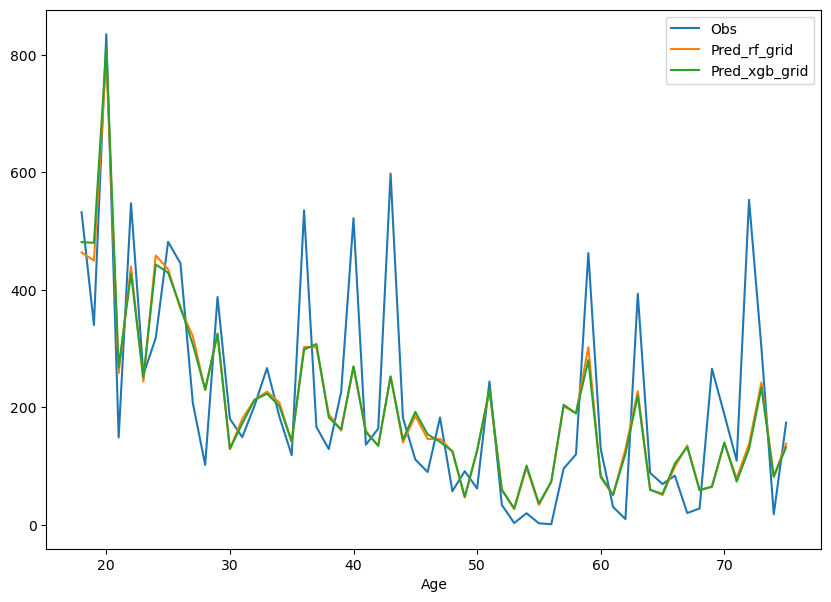

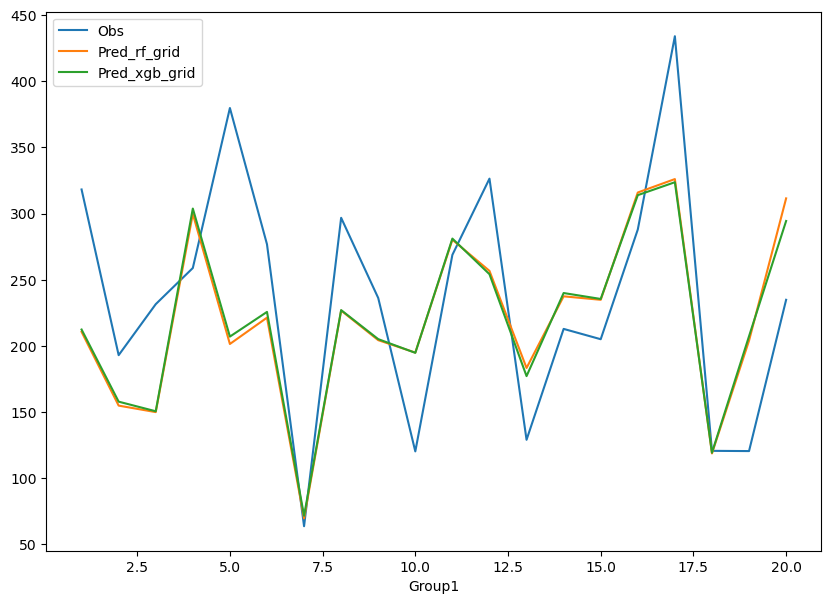

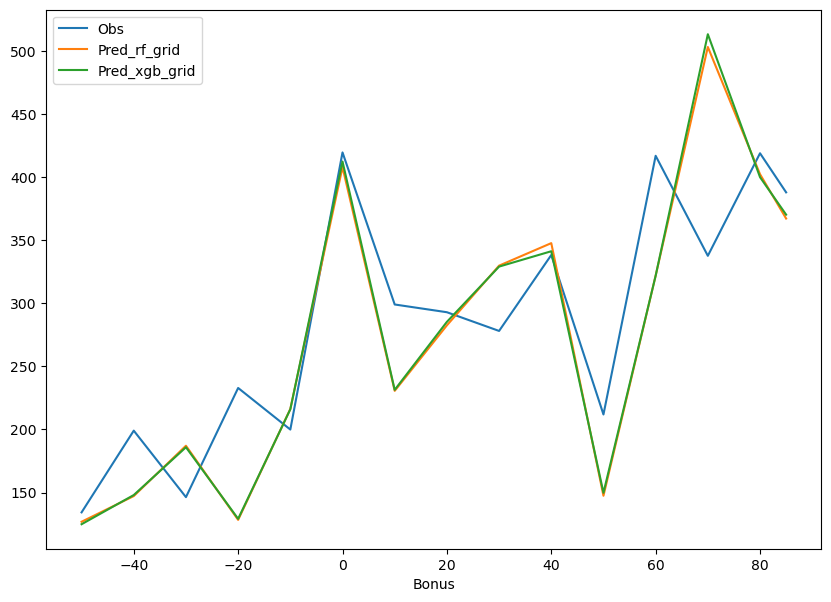

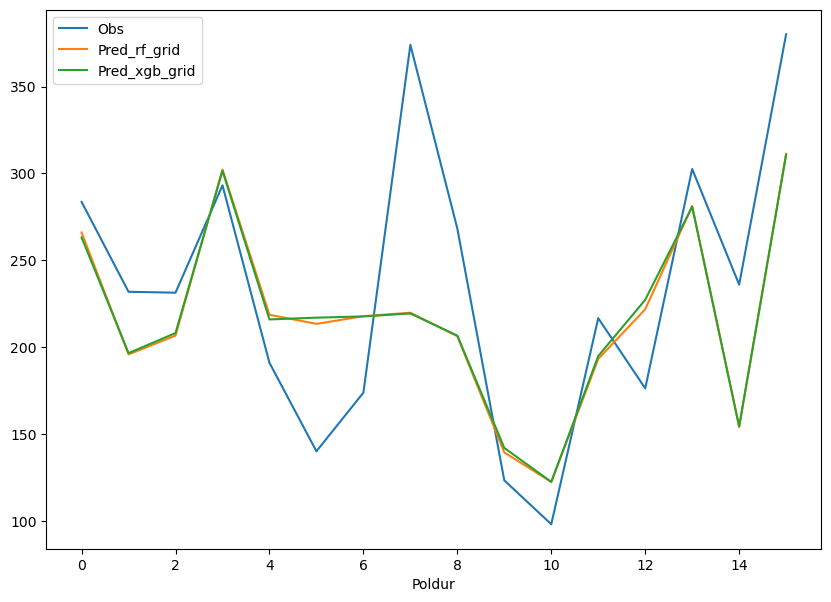

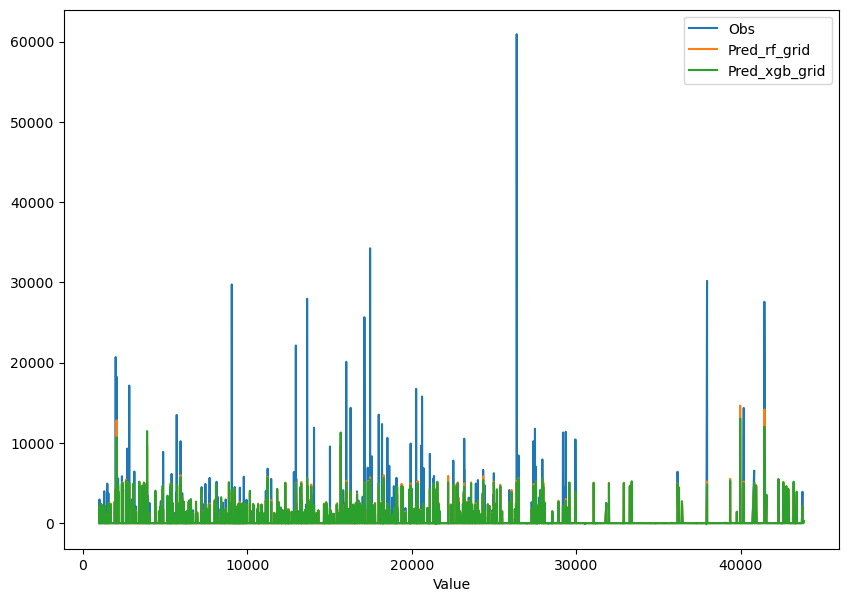

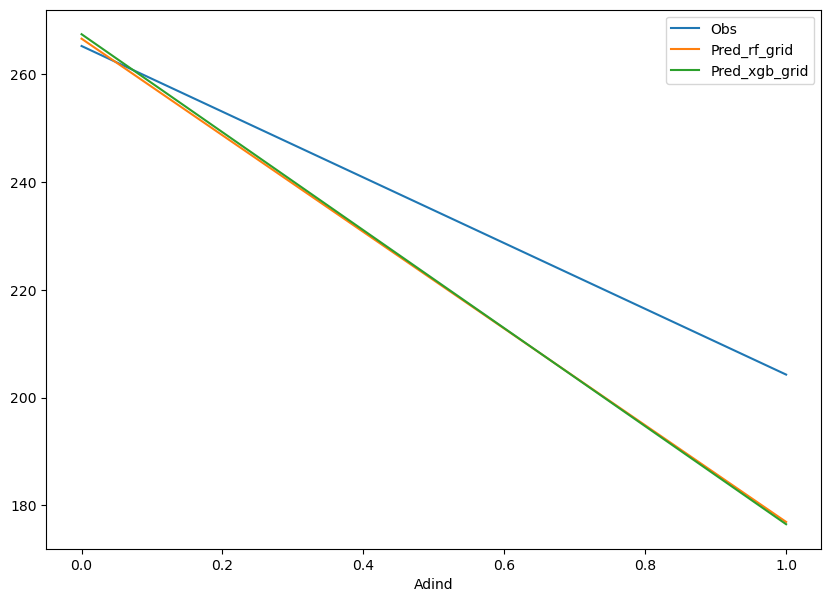

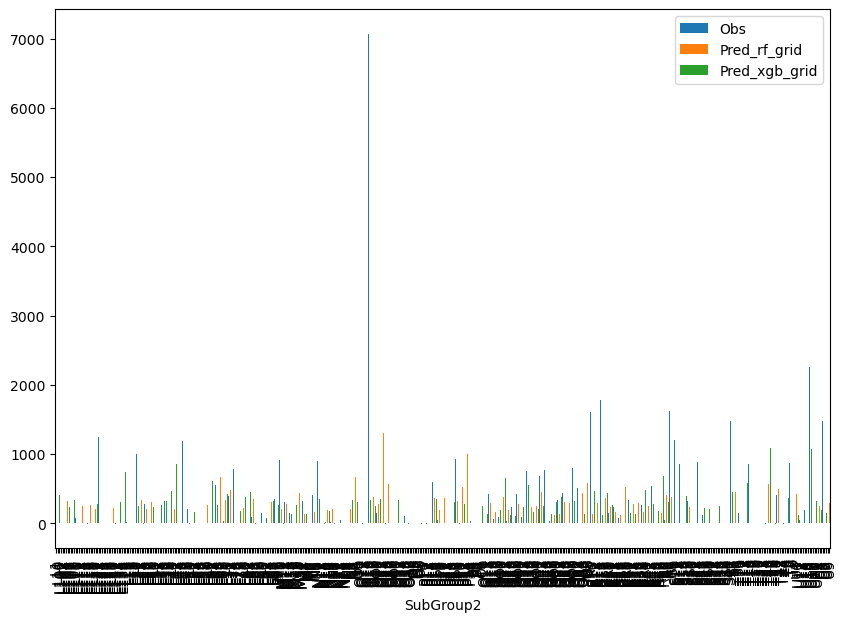

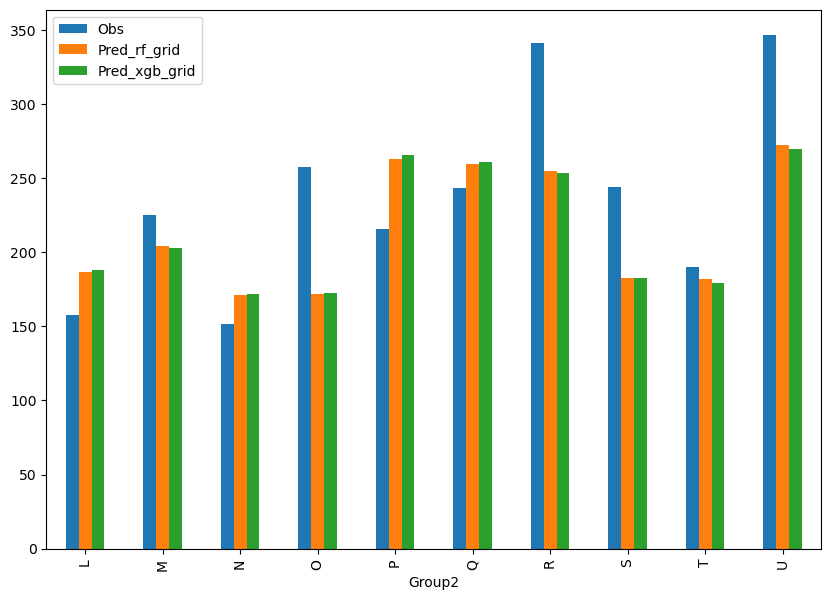

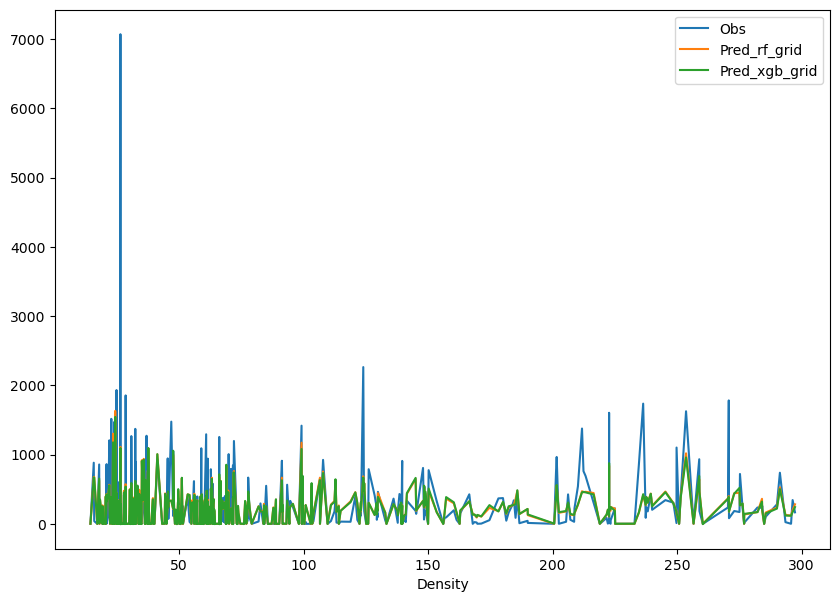

In [132]:
#Impact of target variable on the remaining variables
dataProv = pd.DataFrame(y_test.index)
dataProv.columns = ['index']
dataProv['Obs'] = np.array(y_test_Ind)
dataProv['Pred_rf_grid'] =  y_pred_rf_grid_Ind
dataProv['Pred_xgb_grid'] = y_pred_xgb_grid_Ind

# dataProv['Pred_xgb_grid'] = p_xgb_grid
dataProv.head()

dataFinale = training_data.copy().reset_index().merge(dataProv)
dataFinale.head()
palette = "deep"

for var in dataFinale.columns[3:16]:
    dataPlot = dataFinale.groupby([var])[['Obs', 'Pred_rf_grid', 'Pred_xgb_grid']].mean()
    
    if dataFinale[var].dtypes == 'O':
        # Créer un graphique à barres avec des couleurs de la palette
        ax = dataPlot.plot(kind='bar', figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))
    else:
        # Créer un graphique linéaire avec des couleurs de la palette
        ax = dataPlot.plot(figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))

plt.show()

#### Step B : Predicting Prime PBI

In [204]:
# List of model names
model_names = ['Linear Regression', 'Polynomial Regression', 'SVR', 'Random Forest', 'Random Forest With GridSearch', 'XGBoost', 'XGBoost With GridSearch', 'ANN']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin, test_predict_poly, test_predict_svr, test_predict_rf_model, y_pred_rf_grid_model, y_pred_xgb_model, y_pred_xgb_grid_model, y_pred_ann_model]

# List of true values for comparison
y_true = y_test  # Assuming y_test contains the true values

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_true, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_true, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_true, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_true, y_pred) for y_pred in all_y_pred]
}

# Debugging: Print shapes of all_y_pred
for i, y_pred in enumerate(all_y_pred):
    print(f'Shape of y_pred_{model_names[i]}: {y_pred.shape}')

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)


Shape of y_pred_Linear Regression: (10003,)
Shape of y_pred_Polynomial Regression: (10003,)
Shape of y_pred_SVR: (10003,)
Shape of y_pred_Random Forest: (10003,)
Shape of y_pred_Random Forest With GridSearch: (10003,)
Shape of y_pred_XGBoost: (10003,)
Shape of y_pred_XGBoost With GridSearch: (10003,)
Shape of y_pred_ANN: (10003, 1)

Predictions DataFrame:


,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_SVR,y_pred_Random Forest,y_pred_Random Forest With GridSearch,y_pred_XGBoost,y_pred_XGBoost With GridSearch,y_pred_ANN
0,0.555991,1.307399e-12,0.099753,0.000000,8.410949e-07,0.001011,0.002261,0.585324
1,-2.833974,4.831691e-13,0.099492,0.000000,8.410949e-07,0.001011,0.002261,0.585324
2,-1.008189,7.958079e-13,0.099827,0.000000,8.410949e-07,0.001011,0.002261,0.585324
3,334.055194,2.850955e+02,285.185641,285.591776,2.857473e+02,284.504700,284.507324,273.859283
4,-1.170761,2.842171e-14,0.099957,0.000000,8.410949e-07,0.001011,0.002261,0.585324
...,...,...,...,...,...,...,...,...
9998,-0.236147,-6.536993e-13,0.099715,0.000000,8.410949e-07,0.001011,0.002261,0.585324
9999,-0.194034,-2.273737e-13,0.099967,0.000000,8.410949e-07,0.001011,0.002261,0.585324
10000,-1.376086,2.842171e-13,0.099959,0.000000,8.410949e-07,0.001011,0.002261,0.585324
10001,-7.236848,-6.536993e-13,0.099544,0.000000,8.410949e-07,0.001011,0.002261,0.605167


In [205]:
print("\nMetrics DataFrame:")
(df_metrics)


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,7.347322e+00,8.858640e+03,9.412035e+01,0.958069
1,Polynomial Regression,4.348188e-13,3.468463e-25,5.889366e-13,1.000000
2,SVR,2.854286e+00,9.417553e+03,9.704408e+01,0.955424
3,Random Forest,3.827326e-01,1.666164e+02,1.290800e+01,0.999211
4,Random Forest With GridSearch,3.557215e-01,1.311393e+02,1.145161e+01,0.999379
5,XGBoost,6.016319e-01,2.384166e+02,1.544074e+01,0.998871
6,XGBoost With GridSearch,4.066371e-01,3.089087e+01,5.557956e+00,0.999854
7,ANN,2.328420e+00,2.878267e+02,1.696546e+01,0.998638
